# Business Challenge: Cohort Analysis for Ironhack Payments (Project 1)

The main objective is to analyze **user cohorts defined by the month of creation of their first cash advance**. We will **track the monthly evolution of key metrics** for these cohorts, enabling IronHack Payments to gain valuable insights into user behavior and the performance of their financial services.

# Metrics to analyze
## We will calculate and analyze the following metrics for each cohort:

- Frequency of Service Usage
- Incident Rate
- Revenue Generated by the Cohort

For the forts metric, **Frequency of Service Usage**, we only need to look at the cash_requests .csv file, and see the frequency of cash requests over time

_We are assuming that the creation of the first cash advance is the date of the Credit Request creation_

In [5]:
#First things first - import the libraries needed for statistical analysis, ploting and dealing with errors which we will need to transform our string dates into datatime onjects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [6]:
data_fees= pd.read_csv("extract - fees - data analyst - .csv")
data_cash= pd.read_csv("extract - cash request - data analyst.csv")

In [7]:
# Let's create copies of our dfs - best practices
fees_df = data_fees.copy()
cash_df = data_cash.copy()

In [8]:
# and have a look at the data structure:

In [9]:
cash_df.head(3)

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.34778+00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.82546+00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


In [10]:
print(cash_df.shape)

(23970, 16)


In [11]:
n_rows_cash = cash_df.shape[0]
n_rows_fees = fees_df.shape[0]

In [12]:
n_rows_cash

23970

In [13]:
n_rows_fees

21061

In [14]:
print(cash_df.isnull().sum())

id                                0
amount                            0
status                            0
created_at                        0
updated_at                        0
user_id                        2103
moderated_at                   7935
deleted_account_id            21866
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
transfer_type                     0
send_at                        7329
recovery_status               20640
reco_creation                 20640
reco_last_update              20640
dtype: int64


In [15]:
#Let's look at the percentages of these null values to understand their impact on the data

In [16]:
nulls_names_cash = [i for i in cash_df.head(0) if cash_df[i].isnull().sum() != 0]
nulls_names_cash

['user_id',
 'moderated_at',
 'deleted_account_id',
 'cash_request_received_date',
 'money_back_date',
 'send_at',
 'recovery_status',
 'reco_creation',
 'reco_last_update']

In [17]:
for i in nulls_names_cash:
    percentage = round(cash_df[i].isnull().sum() / cash_df.shape[0] * 100, 2)
    print(f"{i}: {percentage}%")

user_id: 8.77%
moderated_at: 33.1%
deleted_account_id: 91.22%
cash_request_received_date: 32.04%
money_back_date: 30.98%
send_at: 30.58%
recovery_status: 86.11%
reco_creation: 86.11%
reco_last_update: 86.11%


## The columns in cash_df with a higher frequency of null values (>80%) are:

In [19]:
for i in nulls_names_cash:
    percentage = (cash_df[i].isnull().sum() / cash_df.shape[0]) * 100
    if percentage > 80:
        print(i)

deleted_account_id
recovery_status
reco_creation
reco_last_update


It makes sense for "deleted_account_id" to have a lot of null values.
In fact, we expect it to be so, meaning that the `cash` dataframe is comprised mostly of accounts that haven't been deleted.

For the "recovery_status", the null values have a specific meaning:
    - the cash request never had a payment incident.
    
    So this column, which is comprised of categorical data relative to the status of payment incidents, could be good for future filtering 

The "reco_last_update" refers to the timestamp of the last recovery case update. If we're interested in analyzing the evolution of payment incidents and how they are resolved over time, this information can be useful, as it indicates the incident closure date.

For the purposes of this project, we are only interested in the the status of the Credit Request, the date of creation, and the status of payment incidents, so we're going to select only those columns to work with, for now (droping the columns we don't need in the copied dataframe we'll be working with).

In [21]:
cash_df = cash_df.drop(columns=["updated_at", "moderated_at", "cash_request_received_date", "reimbursement_date", "reco_creation", "send_at", "reco_last_update", "money_back_date"])
print(cash_df.shape)
cash_df.head(3)

(23970, 8)


,id,amount,status,created_at,user_id,deleted_account_id,transfer_type,recovery_status
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00,804.0,NaN,regular,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.34778+00,231.0,NaN,regular,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.82546+00,191.0,NaN,regular,NaN


In [22]:
print(cash_df.isnull().sum())

id                        0
amount                    0
status                    0
created_at                0
user_id                2103
deleted_account_id    21866
transfer_type             0
recovery_status       20640
dtype: int64


In [23]:
# For now, we would only need the unique identity of users within the `cash` dataframe in order to count unique users within cohorts.
# Because deleted_account_ids were atributted specifficaly to users who have deleted their accounts, I will fill the null values in user_id with the respective deleted_account_id
# I will transform the deleted_account_id afterwards to keep the information about which accounts have been deleted

In [24]:
cash_df['filled_user_id'] = cash_df['user_id'].fillna(cash_df['deleted_account_id'])
cash_df.drop(columns=['user_id'], inplace=True)

In [25]:
print(cash_df.isnull().sum())

id                        0
amount                    0
status                    0
created_at                0
deleted_account_id    21866
transfer_type             0
recovery_status       20640
filled_user_id            0
dtype: int64


In [26]:
# We can transform the "deleted_account_id" in a categorical, because the only information I might be interested in is if a given account has been deleted or not

In [27]:
cash_df['account_deleted'] = cash_df['deleted_account_id'].notna()

In [28]:
cash_df.drop(columns=['deleted_account_id'], inplace=True)

In [29]:
cash_df["account_deleted"].value_counts() #A total od 2104 accounts have been deleted

account_deleted
False    21866
True      2104
Name: count, dtype: int64

In [30]:
cash_df.duplicated().sum()

0

In [31]:
print(cash_df.isnull().sum())

id                     0
amount                 0
status                 0
created_at             0
transfer_type          0
recovery_status    20640
filled_user_id         0
account_deleted        0
dtype: int64


In [32]:
cash_df.recovery_status.unique()

array([nan, 'completed', 'pending', 'pending_direct_debit', 'cancelled'],
      dtype=object)

In [33]:
#Here, I want to fill the null values with "no payment incident"
cash_df['recovery_status'] = cash_df['recovery_status'].fillna('no payment incident')

In [34]:
print(cash_df.isnull().sum())

id                 0
amount             0
status             0
created_at         0
transfer_type      0
recovery_status    0
filled_user_id     0
account_deleted    0
dtype: int64


In [35]:
print(cash_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               23970 non-null  int64  
 1   amount           23970 non-null  float64
 2   status           23970 non-null  object 
 3   created_at       23970 non-null  object 
 4   transfer_type    23970 non-null  object 
 5   recovery_status  23970 non-null  object 
 6   filled_user_id   23970 non-null  float64
 7   account_deleted  23970 non-null  bool   
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 1.3+ MB
None


In [36]:
# Let's cast "id" and "filled_user_id" as categorical data - since they are identifiers

In [37]:
cash_df['filled_user_id'] = cash_df['filled_user_id'].astype('category')
cash_df['id'] = cash_df['id'].astype('category')

In [38]:
num_cash = cash_df.select_dtypes(include="number")
num_cash

,amount
0,100.0
1,100.0
2,100.0
3,99.0
4,100.0
...,...
23965,100.0
23966,50.0
23967,100.0
23968,100.0


In [39]:
num_cash.describe()

,amount
count,23970.000000
mean,82.720818
std,26.528065
min,1.000000
25%,50.000000
50%,100.000000
75%,100.000000
max,200.000000


In [40]:
cat_cash = cash_df.select_dtypes(exclude="number")
cat_cash

,id,status,created_at,transfer_type,recovery_status,filled_user_id,account_deleted
0,5,rejected,2019-12-10 19:05:21.596873+00,regular,no payment incident,804.0,False
1,70,rejected,2019-12-10 19:50:12.34778+00,regular,no payment incident,231.0,False
2,7,rejected,2019-12-10 19:13:35.82546+00,regular,no payment incident,191.0,False
3,10,rejected,2019-12-10 19:16:10.880172+00,regular,no payment incident,761.0,False
4,1594,rejected,2020-05-06 09:59:38.877376+00,regular,no payment incident,7686.0,False
...,...,...,...,...,...,...,...
23965,20616,money_back,2020-10-12 13:54:11.686225+00,instant,no payment incident,13681.0,False
23966,25243,money_back,2020-10-27 14:41:25.73491+00,instant,completed,30367.0,True
23967,22357,money_back,2020-10-20 07:58:04.006937+00,instant,no payment incident,82122.0,False
23968,20256,money_back,2020-10-10 05:40:55.700422+00,instant,no payment incident,64517.0,False


In [41]:
# This looks good!

In [42]:
# Now, we just have to create our cohorts! Let's find a way to extract year and month from the date column and use it with "group_by"

In [43]:
cash_df.created_at.dtype

dtype('O')

In [44]:
cash_df['created_at'] = pd.to_datetime(cash_df['created_at'])

In [45]:
cash_df['cohort'] = cash_df.groupby('filled_user_id')['created_at'].transform('min').dt.to_period('M')

In [46]:
cash_df.head()

,id,amount,status,created_at,transfer_type,recovery_status,filled_user_id,account_deleted,cohort
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00:00,regular,no payment incident,804.0,False,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780+00:00,regular,no payment incident,231.0,False,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460+00:00,regular,no payment incident,191.0,False,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00:00,regular,no payment incident,761.0,False,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00:00,regular,no payment incident,7686.0,False,2020-05


In [47]:
# Let's also remove the "created_at" column:
cash_df.drop(columns=['created_at'], inplace=True)

In [48]:
cash_df.shape

(23970, 8)

In [49]:
cash_df.cohort.dtype

period[M]

In [50]:
cat_cash = cash_df.select_dtypes(exclude="number")
cat_cash

,id,status,transfer_type,recovery_status,filled_user_id,account_deleted,cohort
0,5,rejected,regular,no payment incident,804.0,False,2019-12
1,70,rejected,regular,no payment incident,231.0,False,2019-12
2,7,rejected,regular,no payment incident,191.0,False,2019-12
3,10,rejected,regular,no payment incident,761.0,False,2019-12
4,1594,rejected,regular,no payment incident,7686.0,False,2020-05
...,...,...,...,...,...,...,...
23965,20616,money_back,instant,no payment incident,13681.0,False,2020-06
23966,25243,money_back,instant,completed,30367.0,True,2020-10
23967,22357,money_back,instant,no payment incident,82122.0,False,2020-10
23968,20256,money_back,instant,no payment incident,64517.0,False,2020-10


In [51]:
#Now, let's look at the value.conts() for each ategorical variable:

In [52]:
print(cash_df['cohort'].value_counts())

cohort
2020-06    5266
2020-10    5058
2020-07    4147
2020-09    2925
2020-05    1660
2020-08    1632
2019-12    1080
2020-04     952
2020-02     441
2020-03     371
2020-01     354
2020-11      76
2019-11       8
Freq: M, Name: count, dtype: int64


In [53]:
print(cash_df['status'].value_counts())

status
money_back               16397
rejected                  6568
direct_debit_rejected      831
active                      59
transaction_declined        48
direct_debit_sent           34
canceled                    33
Name: count, dtype: int64


In [54]:
print(cash_df['transfer_type'].value_counts())

transfer_type
instant    13882
regular    10088
Name: count, dtype: int64


In [55]:
print(cash_df['account_deleted'].value_counts())

account_deleted
False    21866
True      2104
Name: count, dtype: int64


In [56]:
frequency_cohort = cash_df['cohort'].value_counts()
proportion_cohort = cash_df['cohort'].value_counts(normalize=True).round(2)

In [57]:
df2 = pd.concat([frequency_cohort, proportion_cohort], axis=1)
df2.columns = ['absolute_frequency', 'relative_frequency']
df2

,absolute_frequency,relative_frequency
cohort,,
2020-06,5266,0.22
2020-10,5058,0.21
2020-07,4147,0.17
2020-09,2925,0.12
2020-05,1660,0.07
2020-08,1632,0.07
2019-12,1080,0.05
2020-04,952,0.04
2020-02,441,0.02


In [58]:
frequency_cohort.sum() == cash_df.shape[0]

True

In [59]:
total_absolute = int(frequency_cohort.sum())
total_relative = int(proportion_cohort.sum())

In [60]:
total_row = pd.DataFrame({
    'absolute_frequency': [total_absolute],
    'relative_frequency': [total_relative]
}, index=['Total'])
total_row

,absolute_frequency,relative_frequency
Total,23970,1


In [61]:
df3 = pd.concat([df2,total_row])
df3

,absolute_frequency,relative_frequency
2020-06,5266,0.22
2020-10,5058,0.21
2020-07,4147,0.17
2020-09,2925,0.12
2020-05,1660,0.07
2020-08,1632,0.07
2019-12,1080,0.05
2020-04,952,0.04
2020-02,441,0.02
2020-03,371,0.02


# 1st Metric: Frequency of Service Usage

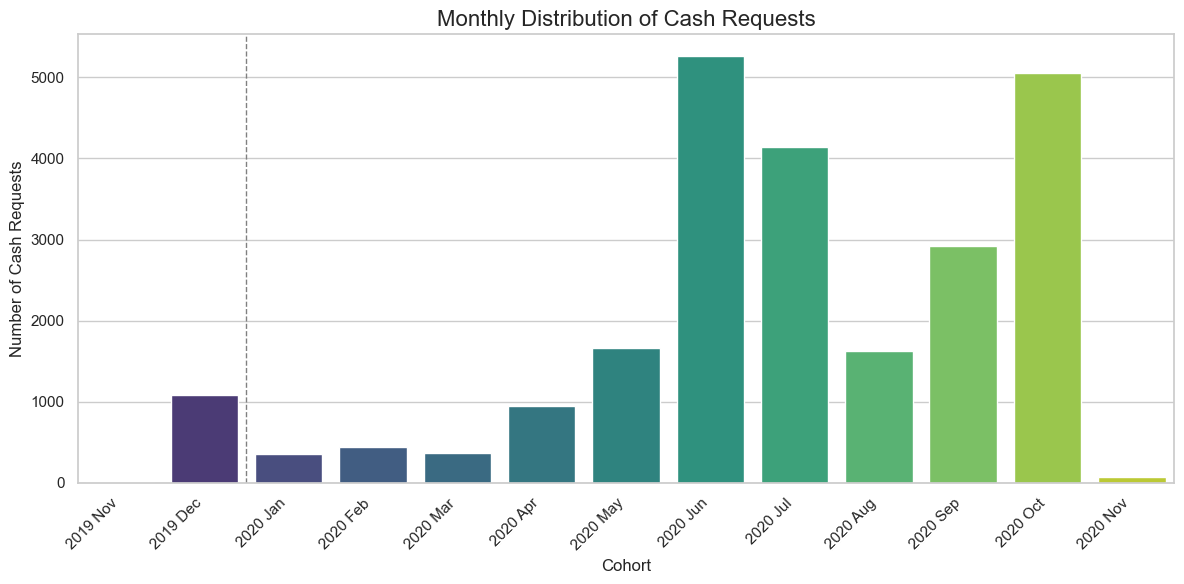

In [63]:
# Count occurrences of each cohort and ensure the index is sorted
cohort_counts = cash_df['cohort'].value_counts().sort_index()

# Convert PeriodIndex to a string format for plotting (e.g., "2019 Nov", "2020 Jan")
abbreviated_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
formatted_index = [
    f"{period.year} {abbreviated_months[period.month - 1]}"
    for period in cohort_counts.index
]

# Plot the bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(
    x=formatted_index,  # Use formatted x-axis labels
    y=cohort_counts.values,  # Use cohort counts as y-axis
    palette='viridis'
)

# Add year separators (if needed)
year_change_index = next((i for i, x in enumerate(formatted_index) if '2020' in x), None)
if year_change_index is not None:
    plt.axvline(year_change_index - 0.5, linestyle='--', color='grey', linewidth=1)

# Customize plot appearance
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Monthly Distribution of Cash Requests", fontsize=16)
plt.xlabel("Cohort", fontsize=12)
plt.ylabel("Number of Cash Requests", fontsize=12)

# Ensure layout fits all labels and elements
plt.tight_layout()
plt.show()

In [64]:
cash_df.cohort.nunique()

13

In [65]:
cash_df.filled_user_id.nunique()

11793

In [124]:
cash_df.filled_user_id.value_counts()

filled_user_id
2142.0      21
6334.0      19
3377.0      19
13851.0     18
2530.0      17
            ..
44488.0      1
44484.0      1
44445.0      1
44436.0      1
103719.0     1
Name: count, Length: 11793, dtype: int64

I want to point out that, because I used .value_counts(), the previous graph is showing the commulative sum of all user interactions for each cohort. 

Because each cohort has several entries for the same user, indicating different instances of usage of cash request services, I needed to take that into consideration if I wanted to plot the total ammount of new requests per month. Otherwise, I would need a different tyoe of plot to se the dynamics of cash request usage for each user in their specific cohorts.
(I would need to do another groupby to count only the number of unique user_ids for each cohort, for example.

I only realised this after presenting this work to my colleagues, with Avitup's help, so I am keeping my original plot and commenting on this for future adjustments.

# Exploring other categorical variables

## Cash Request Status

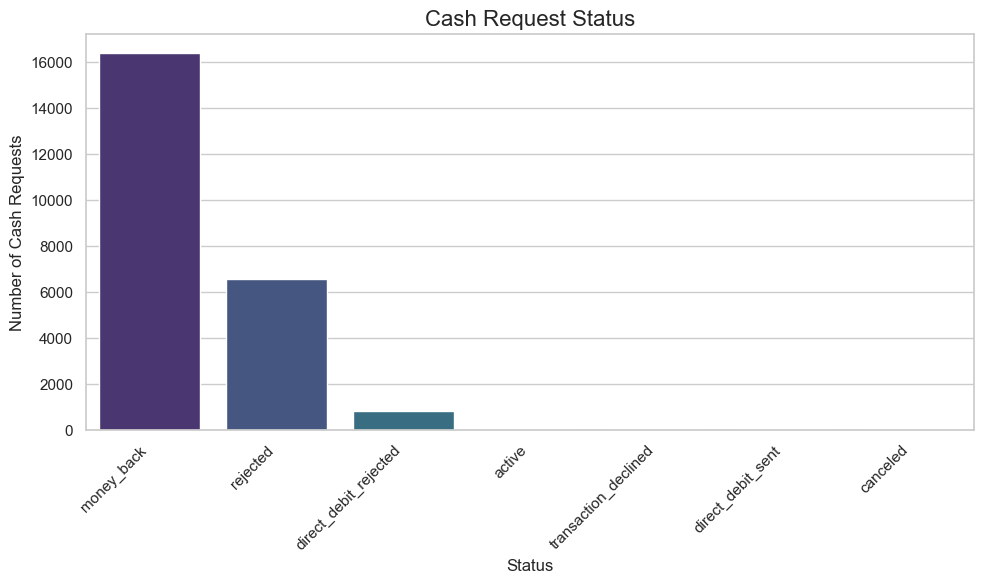

In [130]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    x=cash_df['status'].value_counts().index, 
    y=cash_df['status'].value_counts().values, 
    palette='viridis'
)

plt.xticks(rotation=45, ha='right') 


plt.title("Cash Request Status", fontsize=16)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Number of Cash Requests", fontsize=12)


plt.tight_layout()  
plt.show()

## Cash Request Type

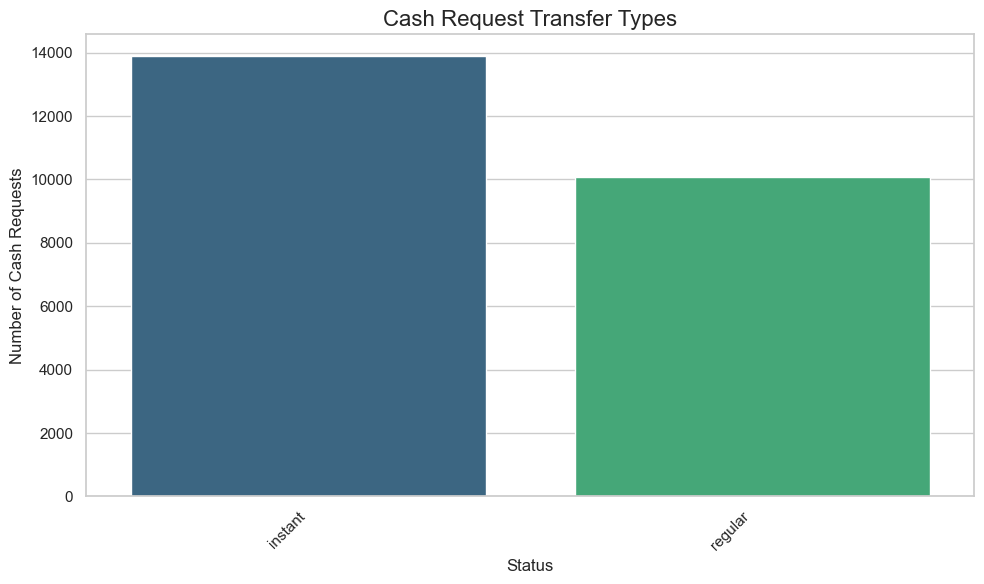

In [133]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))  
sns.barplot(
    x=cash_df['transfer_type'].value_counts().index,  
    y=cash_df['transfer_type'].value_counts().values, 
    palette='viridis'
)

plt.xticks(rotation=45, ha='right') 

plt.title("Cash Request Transfer Types", fontsize=16)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Number of Cash Requests", fontsize=12)

plt.tight_layout()  
plt.show()

In [135]:
cohort_type_table = pd.crosstab(cash_df["cohort"], cash_df["transfer_type"])

In [137]:
cohort_type_table

transfer_type,instant,regular
cohort,,
2019-11,4,4
2019-12,170,910
2020-01,60,294
2020-02,84,357
2020-03,80,291
2020-04,207,745
2020-05,496,1164
2020-06,1924,3342
2020-07,2016,2131


<Figure size 1200x600 with 0 Axes>

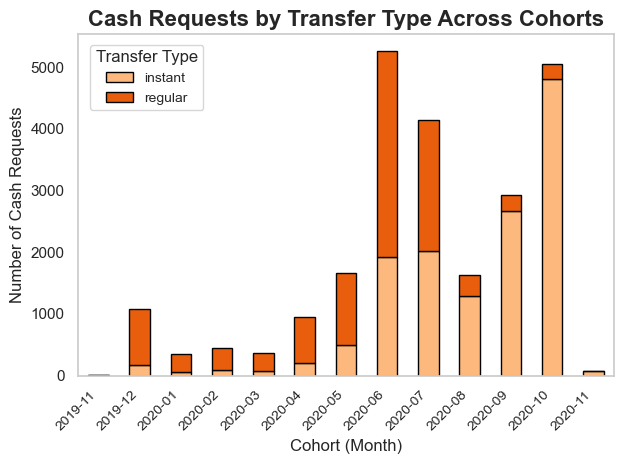

In [139]:
# Create the bar plot
plt.figure(figsize=(12, 6))  # Set figure size

# Generate colors from the Set2 palette
colors = sns.color_palette('Oranges', n_colors=cohort_type_table.shape[1])

# Create the stacked bar plot with the Set2 colors
cohort_type_table.plot(
    kind='bar',
    stacked=True,
    color=colors,  # Apply Set2 colors
    edgecolor='black'  # Add borders to bars for a cleaner look
)

# Customize x-axis
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels 45 degrees
plt.xlabel("Cohort (Month)", fontsize=12)  # Label for x-axis
plt.ylabel("Number of Cash Requests", fontsize=12)  # Label for y-axis

# Customize title
plt.title("Cash Requests by Transfer Type Across Cohorts", fontsize=16, fontweight='bold')

# Remove grid
plt.grid(False)

# Adjust legend
plt.legend(title="Transfer Type", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(0.01, 0.99))

# Show the plot
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

In [141]:
cohort_status_table = pd.crosstab(cash_df["cohort"], cash_df["status"])

In [143]:
cohort_status_table

status,active,canceled,direct_debit_rejected,direct_debit_sent,money_back,rejected,transaction_declined
cohort,,,,,,,
2019-11,0,1,0,0,6,1,0
2019-12,0,1,41,2,690,345,1
2020-01,0,0,11,0,215,128,0
2020-02,1,0,8,0,330,101,1
2020-03,1,0,4,1,277,88,0
2020-04,0,0,34,1,642,275,0
2020-05,1,1,41,2,1192,423,0
2020-06,12,14,126,4,3415,1687,8
2020-07,14,3,136,3,2338,1648,5


<Figure size 1200x600 with 0 Axes>

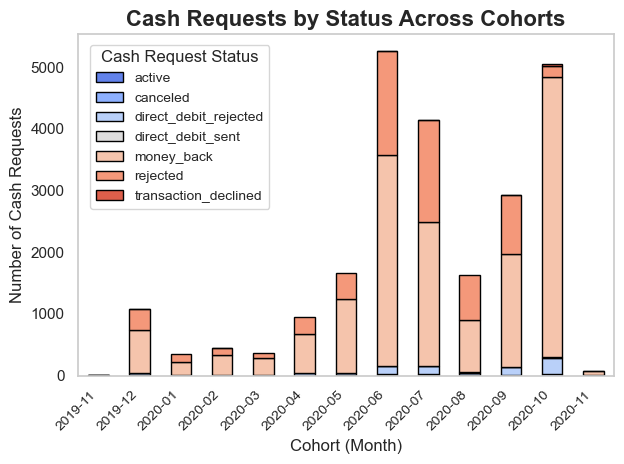

In [145]:
plt.figure(figsize=(12, 6))  # Set figure size

# Generate colors from the Set2 palette
colors = sns.color_palette('coolwarm', n_colors=cohort_status_table.shape[1])

# Create the stacked bar plot with the Set2 colors
cohort_status_table.plot(
    kind='bar',
    stacked=True,
    color=colors,  # Apply Set2 colors
    edgecolor='black'  # Add borders to bars for a cleaner look
)

# Customize x-axis
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels 45 degrees
plt.xlabel("Cohort (Month)", fontsize=12)  # Label for x-axis
plt.ylabel("Number of Cash Requests", fontsize=12)  # Label for y-axis

# Customize title
plt.title("Cash Requests by Status Across Cohorts", fontsize=16, fontweight='bold')

# Remove grid
plt.grid(False)

# Adjust legend
plt.legend(title="Cash Request Status", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(0.01, 0.99))

# Show the plot
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

In [147]:
#Now, let's look at the data from our fees dataframe:

In [149]:
fees_df.head(3)

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after


In [151]:
print(fees_df.shape)

(21061, 13)


In [153]:
print(fees_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB
None


In [155]:
# I want to cast `id`and `cash_request_id` as categorical:
fees_df['cash_request_id'] = fees_df['cash_request_id'].astype('category')
fees_df['id'] = fees_df['id'].astype('category')

In [157]:
cat_fees = fees_df.select_dtypes(exclude="number")
cat_fees.head(3)

,id,cash_request_id,type,status,category,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after


In [159]:
num_fees = fees_df.select_dtypes(include="number")
num_fees.head(3)

,total_amount
0,5.0
1,5.0
2,5.0


In [161]:
print(fees_df.isnull().sum())

id                     0
cash_request_id        4
type                   0
status                 0
category           18865
total_amount           0
reason                 0
created_at             0
updated_at             0
paid_at             5530
from_date          13295
to_date            13295
charge_moment          0
dtype: int64


In [163]:
# The "category" column is applied only to incident fees, and should be null for the other entries
# I can fill this nulls with "not applicable"
# We can do the same for the nulls in the other variables (paid_at, from_date, to_date)

In [165]:
fees_df['created_at'] = pd.to_datetime(fees_df['created_at'])
fees_df['updated_at'] = pd.to_datetime(fees_df['updated_at'])
fees_df['paid_at'] = pd.to_datetime(fees_df['paid_at'], errors='coerce') # needs to be done where we have filled the null values
fees_df['from_date'] = pd.to_datetime(fees_df['from_date'], errors='coerce')
fees_df['to_date'] = pd.to_datetime(fees_df['to_date'], errors='coerce')

In [167]:
fees_df['category'] = fees_df['category'].fillna('not applicable')
fees_df['paid_at'] = fees_df['paid_at'].fillna('not applicable')
fees_df['from_date'] = fees_df['from_date'].fillna('not applicable')
fees_df['to_date'] = fees_df['to_date'].fillna('not applicable')

In [169]:
print(fees_df.isnull().sum())

id                 0
cash_request_id    4
type               0
status             0
category           0
total_amount       0
reason             0
created_at         0
updated_at         0
paid_at            0
from_date          0
to_date            0
charge_moment      0
dtype: int64


In [171]:
# And now we're only left with 4 null values for the cash_request_id. Because we need to merge these two dataframes by the id of the cash request, if we do an "inner" merge, the rows with these null values will be automatically removed,

In [173]:
fees_df.created_at.dtype

datetime64[ns, UTC]

In [175]:
fees_df.describe()

,total_amount
count,21061.000000
mean,5.000237
std,0.034453
min,5.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,10.000000


In [177]:
#Now we need to merge our dataframes. There are 4 entries with null values for "cash_request_id", I expect them to be removed during this merge
merged_df = pd.merge(fees_df, cash_df, left_on='cash_request_id', right_on='id', how='inner',suffixes=('_fees', '_cash'))  # Suffixes for overlapping columns

# Important note:

I did an inner merge here because I had already done the cohort frequency usage analysis, so I did not need to keep all the user data for users who didn't have fees to continue doing this project.

**but**, for future reference, it is better to join first (left or right, not inner) and then define the cohorts!

In [180]:
merged_df.isnull().sum()

id_fees            0
cash_request_id    0
type               0
status_fees        0
category           0
total_amount       0
reason             0
created_at         0
updated_at         0
paid_at            0
from_date          0
to_date            0
charge_moment      0
id_cash            0
amount             0
status_cash        0
transfer_type      0
recovery_status    0
filled_user_id     0
account_deleted    0
cohort             0
dtype: int64

In [182]:
merged_df.type.value_counts()

type
instant_payment    11095
postpone            7766
incident            2196
Name: count, dtype: int64

In [184]:
merged_df["cash_request_id"].shape

(21057,)

In [186]:
fees_df["cash_request_id"].shape

(21061,)

In [188]:
cash_df["id"].shape

(23970,)

In [190]:
# We can see that we lost some entries in this merge - not all cash_request ids matched the ones from our cash dataframe.

In [192]:
merged_df.head(3)

,id_fees,cash_request_id,type,status_fees,category,total_amount,reason,created_at,updated_at,paid_at,...,to_date,charge_moment,id_cash,amount,status_cash,transfer_type,recovery_status,filled_user_id,account_deleted,cohort
0,6537,14941.0,instant_payment,rejected,not applicable,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.470110+00:00,...,not applicable,after,14941,100.0,direct_debit_rejected,instant,pending,35661.0,False,2020-09
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.459080+00:00,...,not applicable,after,11714,100.0,money_back,instant,completed,16158.0,False,2020-06
2,16296,23371.0,instant_payment,accepted,not applicable,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.432910+00:00,...,not applicable,after,23371,100.0,money_back,instant,no payment incident,81575.0,False,2020-10


In [194]:
# Now we need to filter for incidents
incidents = merged_df[merged_df['type'] == 'incident']

In [196]:
print(incidents['filled_user_id'].nunique())

1394


In [198]:
print(merged_df['filled_user_id'].nunique())

9150


In [200]:
# Frequency of users with incidents:
print(round(float(incidents['filled_user_id'].nunique() / (merged_df['filled_user_id'].nunique())), 2) * 100, "%")

15.0 %


In [202]:
users_with_incidents = incidents['filled_user_id'].unique()
cash_df['has_incident'] = cash_df['filled_user_id'].isin(users_with_incidents)

# Compute incident rate by cohort
incident_rate = cash_df.groupby('cohort')['has_incident'].mean()

In [204]:
print(incident_rate)

cohort
2019-11    0.000000
2019-12    0.228704
2020-01    0.149718
2020-02    0.235828
2020-03    0.296496
2020-04    0.318277
2020-05    0.348795
2020-06    0.334220
2020-07    0.256571
2020-08    0.168505
2020-09    0.088547
2020-10    0.005140
2020-11    0.000000
Freq: M, Name: has_incident, dtype: float64


# 2nd metric: Incident Rate

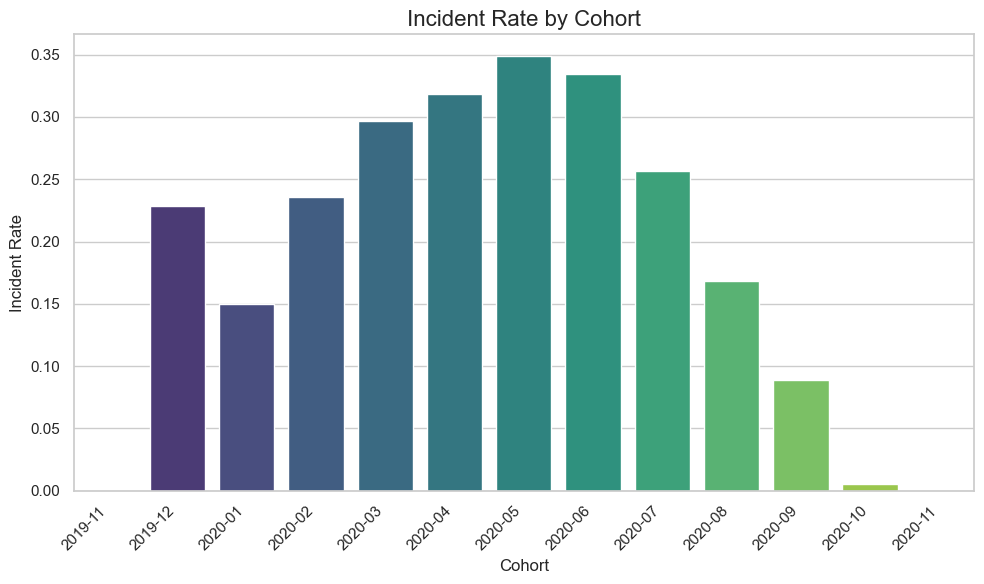

In [207]:
plt.figure(figsize=(10, 6))

# Create a barplot using seaborn
sns.barplot(
    x=incident_rate.index,  # x-axis: cohort names
    y=incident_rate.values,  # y-axis: incident rates
    palette='viridis'  # Use the 'viridis' colormap for colors
)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and align to the right

# Add title and labels
plt.title("Incident Rate by Cohort", fontsize=16)
plt.xlabel("Cohort", fontsize=12)
plt.ylabel("Incident Rate", fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# 3rd metric: Revenue Generated by the Cohorts

In [210]:
accepted_fees = merged_df[merged_df["status_fees"] == "accepted"]

In [212]:
accepted_fees.groupby(['cohort', 'paid_at'])['total_amount'].sum()

cohort   paid_at                         
2019-11  2020-07-14 14:59:48.909393+00:00    5.0
         2020-09-01 10:54:17.647566+00:00    5.0
         2020-10-08 20:50:51.604063+00:00    5.0
         2020-10-28 08:04:45.811783+00:00    5.0
         2020-11-11 06:53:41.247040+00:00    5.0
                                            ... 
2020-11  2021-01-02 01:39:44.668826+00:00    5.0
         2021-01-05 17:16:44.629610+00:00    5.0
         2021-01-07 13:07:07.319187+00:00    5.0
         2021-01-08 02:57:29.780880+00:00    5.0
         2021-02-05 20:48:23.296980+00:00    5.0
Name: total_amount, Length: 14457, dtype: float64

In [214]:
cohort_revenue = accepted_fees.groupby('cohort')['total_amount'].sum()
cohort_revenue

cohort
2019-11       30.0
2019-12     1130.0
2020-01      460.0
2020-02      635.0
2020-03      645.0
2020-04     1585.0
2020-05     3930.0
2020-06    14365.0
2020-07    11135.0
2020-08     5045.0
2020-09    11400.0
2020-10    23530.0
2020-11      320.0
Freq: M, Name: total_amount, dtype: float64

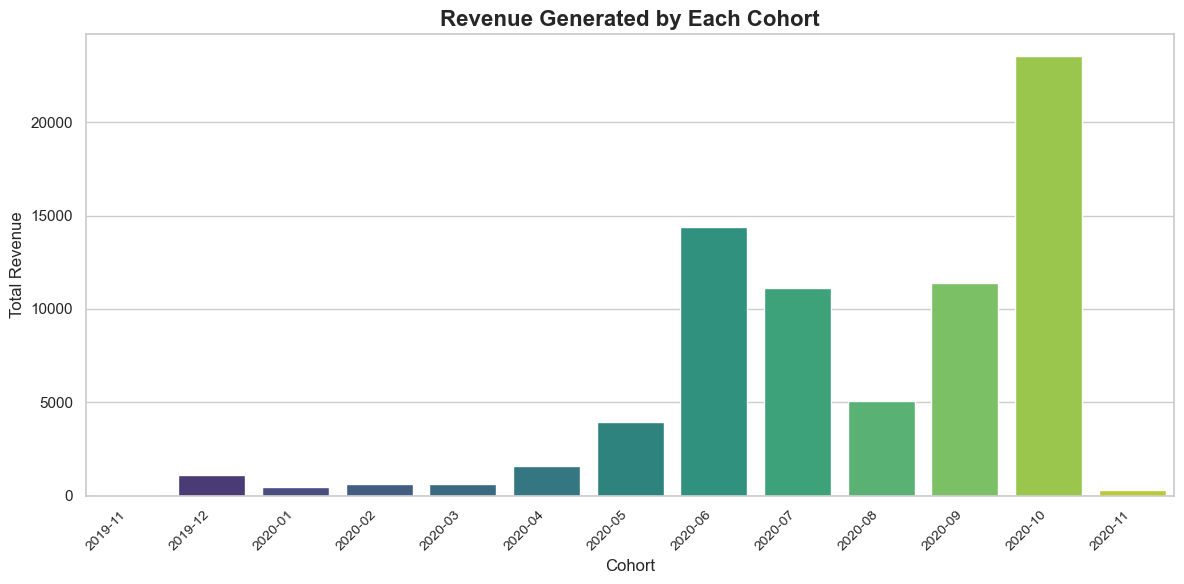

In [216]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=cohort_revenue.index, 
    y=cohort_revenue.values, 
    palette='viridis' 
)


plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.title("Revenue Generated by Each Cohort", fontsize=16, fontweight='bold')
plt.xlabel("Cohort", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.tight_layout()


plt.show()
